In [1]:
import os
import sys
sys.path.append("MaskRCNN")
import random
import math
import re
import time
import numpy as np
import cv2
import skimage
import matplotlib
import matplotlib.pyplot as plt

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# from tqdm.notebook import tqdm
from tqdm.auto import tqdm
from tqdm.keras import TqdmCallback

import warnings
# warnings.filterwarnings("ignore")

D:\ProgramData\Anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\ProgramData\Anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\ProgramData\Anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\ProgramData\Anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\f

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9924787072098946700
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7103525684
locality {
  bus_id: 1
}
incarnation: 1773031188055520466
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [2]:

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Directory to load source dataset
DATA_DIR = os.path.join(ROOT_DIR, "processed_data\\leftImg8bit")

# Directory to load groundtruth dataset
MASK_DIR = os.path.join(ROOT_DIR, "processed_data\\gtFine")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "MaskRCNN\\mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

TRAINING = False
subset = ''

In [3]:
class CityscapeConfig(Config):
    """Configuration for training on the cityscape dataset.
    Derives from the base Config class and overrides values specific
    to the cityscape dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cityscape"

    # We use a GPU with 12GB memory.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1  # 8

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 1000

    # Number of validation steRPNps to run at the end of every training epoch.
    VALIDATION_STEPS = 300

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"

    # Number of classes (including background)
    NUM_CLASSES = 1 + 6  # background + 1 shapes

    # Input image resing
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Learning rate and momentum
    LEARNING_RATE = 0.01
    
    # min confidence which we train on
    DETECTION_MIN_CONFIDENCE = 0.5
config = CityscapeConfig()

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax


In [5]:
class CityscapeDataset(utils.Dataset):
    '''
    load_shapes()
    load_image()
    load_mask()
    '''

    def __init__(self, subset, max_images=0):
        super(CityscapeDataset, self).__init__(self)
        self.subset = subset
        self.max_images = max_images
        self.classids = {
            "sidewalk" : 1,
            "car" : 2,
            "truck" : 3,
            "bus" : 4,
            "motorcycle" : 5,
            "bicycle" : 6,
        }

    def load_shapes(self):
        """
        subset: "train"/"val"
        image_id: use index to distinguish the images.
        gt_id: ground truth(mask) id.
        height, width: the size of the images.
        path: directory to load the images.
        """
        # Add classes you want to train
        self.add_class("cityscape", 1, "sidewalk")
        self.add_class("cityscape", 2, "car")
        self.add_class("cityscape", 3, "truck")
        self.add_class("cityscape", 4, "bus")
        self.add_class("cityscape", 5, "motorcycle")
        self.add_class("cityscape", 6, "bicycle")

        # Add images
        image_dir = "{}/{}".format(DATA_DIR, self.subset)
        image_ids = os.listdir(image_dir)
        if self.max_images != 0:
            # image_ids = image_ids[:self.max_images]
            image_ids = np.random.choice(image_ids, self.max_images)
        
        for index, item in tqdm(enumerate(image_ids), desc='preparing dataset'):
            temp_image_path = "{}/{}".format(image_dir, item)
            temp_image_size = skimage.io.imread(temp_image_path).shape
            gt_id = os.path.splitext(item)[0]
            mask_dir = "{}\\{}\\{}".format(MASK_DIR, self.subset, gt_id)
            try:
                # if path doesn't exist, it will throw error and not add the image
                os.listdir(mask_dir)
                self.add_image("cityscape", image_id=index, gt_id=gt_id,
                                height=temp_image_size[0], width=temp_image_size[1],
                                path=temp_image_path)
            except Exception:
                print(f'{mask_dir} doesn\'t exist, skipping {gt_id}')


    def load_image(self, image_id):
        """Load images according to the given image ID."""
        info = self.image_info[image_id]
        image = skimage.io.imread(info['path'])
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "cityscape":
            return info["cityscape"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Load instance masks of the given image ID.
        count: the number of masks in each image.
        class_id: the first letter of each mask file's name.
        """
        info = self.image_info[image_id]
        gt_id = info['gt_id']
        # cityscapes = info["cityscape"]
        mask_dir = "{}\\{}\\{}".format(MASK_DIR, self.subset, gt_id)
        masks_list = os.listdir(mask_dir)
        count = len(masks_list)
        mask = np.zeros([info['height'], info['width'], count])
        class_ids = []

        for index, item in enumerate(masks_list):
            temp_mask_path = "{}\\{}".format(mask_dir, item)
            tmp_mask = 255 - skimage.io.imread(temp_mask_path)[:, :, np.newaxis]
            label_name = item.replace('.png','')
            label_name = label_name.split('_')
            label_name = label_name[len(label_name) - 1]
            id_class = self.classids[label_name]
            # print(item, tmp_mask.shape)
            mask[:, :, index:index+1] = tmp_mask
            class_ids.append(id_class)

        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
            
        # class_ids = np.array([self.class_names.index(c[0]) for c in cityscapes])
        # np.savetxt('mask.out', mask.reshape(mask.shape[0], -1), delimiter=',', fmt='.2f')
        # from PIL import Image
        # for i in range(count):
        #     im = Image.fromarray(mask[:, :, i])
        #     im = im.convert('L')
        #     im.save(f'{gt_id}_{i}.png')
        return mask, np.array(class_ids, dtype=np.uint8)


In [6]:
# np.array(['a'], dtype=np.uint8)

In [7]:
if TRAINING:
    # Training dataset
    dataset_train = CityscapeDataset("train", 300)
    dataset_train.load_shapes()
    dataset_train.prepare()

# Validation dataset
dataset_val = CityscapeDataset("val")
dataset_val.load_shapes()
dataset_val.prepare()

preparing dataset: 287it [00:21, 12.78it/s]

c:\Users\Soham\Dropbox (ASU)\ASU_StudyMaterials\Fall21\SML\Project\mask_r_cnn_sml\processed_data\gtFine\val\lindau_000017_000019 doesn't exist, skipping lindau_000017_000019
c:\Users\Soham\Dropbox (ASU)\ASU_StudyMaterials\Fall21\SML\Project\mask_r_cnn_sml\processed_data\gtFine\val\lindau_000018_000019 doesn't exist, skipping lindau_000018_000019
c:\Users\Soham\Dropbox (ASU)\ASU_StudyMaterials\Fall21\SML\Project\mask_r_cnn_sml\processed_data\gtFine\val\lindau_000019_000019 doesn't exist, skipping lindau_000019_000019


preparing dataset: 309it [00:22, 13.20it/s]

c:\Users\Soham\Dropbox (ASU)\ASU_StudyMaterials\Fall21\SML\Project\mask_r_cnn_sml\processed_data\gtFine\val\lindau_000040_000019 doesn't exist, skipping lindau_000040_000019


preparing dataset: 315it [00:23, 12.91it/s]

c:\Users\Soham\Dropbox (ASU)\ASU_StudyMaterials\Fall21\SML\Project\mask_r_cnn_sml\processed_data\gtFine\val\lindau_000045_000019 doesn't exist, skipping lindau_000045_000019


preparing dataset: 500it [00:36, 13.52it/s]


In [8]:
# Inspect the dataset
# print("Image Count: {}".format(len(dataset_train.image_ids)))
# print("Class Count: {}".format(dataset_train.num_classes))
# for i, info in enumerate(dataset_train.class_info):
#     print("{:3}. {:50}".format(i, info['name']))

# Load and display random samples
# image_ids = np.random.choice(dataset_train.image_ids, 3)
# for image_id in image_ids:
#     image = dataset_train.load_image(image_id)
#     print('image_id', image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids,
#                                 dataset_train.class_names)

In [9]:
# # Create model in training mode
# model = modellib.MaskRCNN(mode="training", config=config,
#                           model_dir=MODEL_DIR)

# # Which weights to start with?
# init_with = "coco"  # imagenet, coco, or last

# if init_with == "imagenet":
#     model.load_weights(model.get_imagenet_weights(), by_name=True)
# elif init_with == "coco":
#     # Load weights trained on MS COCO, but skip layers that
#     # are different due to the different number of classes
#     # See README for instructions to download the COCO weights
#     model.load_weights(COCO_MODEL_PATH, by_name=True,
#                        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
#                                 "mrcnn_bbox", "mrcnn_mask"])
# elif init_with == "last":
#     # Load the last model you trained and continue training
#     model.load_weights(model.find_last()[1], by_name=True)


In [10]:
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     if TRAINING:
#         # tqdm bar for tracking training progress
#         callback = TqdmCallback()
#         callback.display()
        
#         # Train the head branches
#         # Passing layers="heads" freezes all layers except the head
#         # layers. You can also pass a regular expression to select
#         # which layers to train by name pattern.
#         # model.train(dataset_train, dataset_val,
#         #             learning_rate=config.LEARNING_RATE,
#         #             epochs=1,
#         #             layers='heads')

#         # Fine tune all layers
#         # Passing layers="all" trains all layers. You can also
#         # pass a regular expression to select which layers to
#         # train by name pattern.
#         # learning_rate = 0.01
#         model.train(dataset_train, dataset_val,
#                     learning_rate=config.LEARNING_RATE,
#                     epochs=3,
#                     layers="all",
#                     custom_callbacks = [callback],
#                     verbose=0
#                     )

#         callback = TqdmCallback()
#         callback.display()
#         # learning_rate = 0.001
#         model.train(dataset_train, dataset_val,
#                     learning_rate=config.LEARNING_RATE / 10,
#                     epochs=4,
#                     layers="all",
#                     custom_callbacks = [callback],
#                     verbose=0
#                     )

#         # Save weights
#         # Typically not needed because callbacks save after every epoch
#         # Uncomment to save manually
#         # model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
#         # model.keras_model.save_weights(model_path)

In [11]:
class InferenceConfig(CityscapeConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 1024
    DETECTION_MIN_CONFIDENCE = 0 

inference_config = InferenceConfig()
print(inference_config.IMAGES_PER_GPU)

1


In [12]:
dataset_val.class_names

['BG', 'sidewalk', 'car', 'truck', 'bus', 'motorcycle', 'bicycle']

Loading weights from  c:\Users\Soham\Dropbox (ASU)\ASU_StudyMaterials\Fall21\SML\Project\mask_r_cnn_sml\logs\cityscape20211201T0242\mask_rcnn_cityscape_0030.h5
Re-starting from epoch 30
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 i

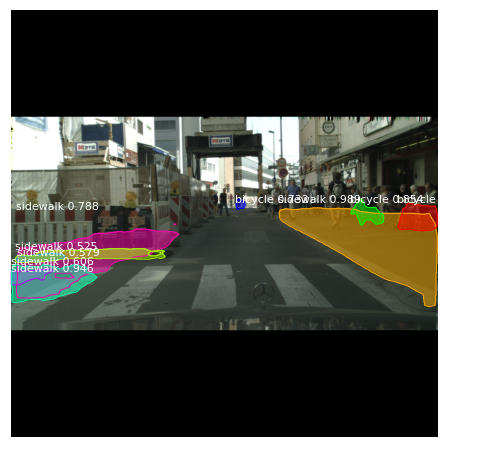

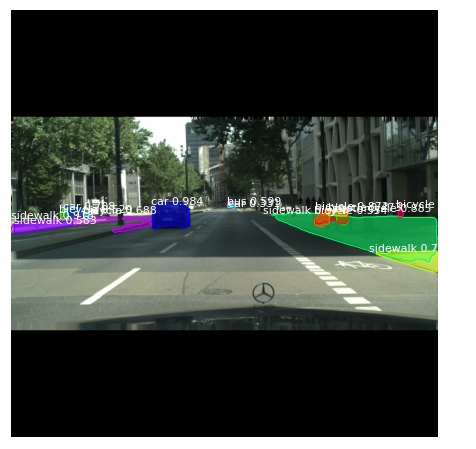

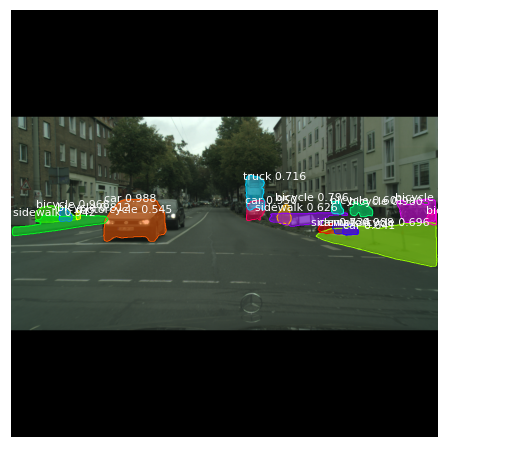

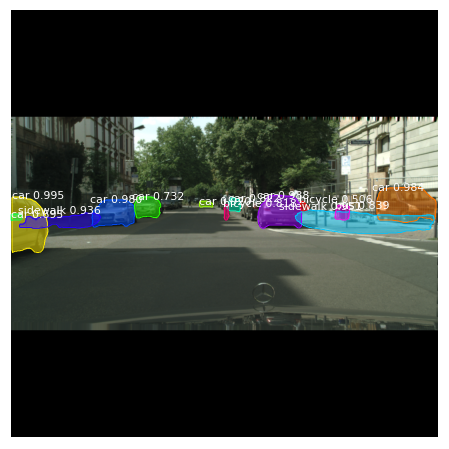

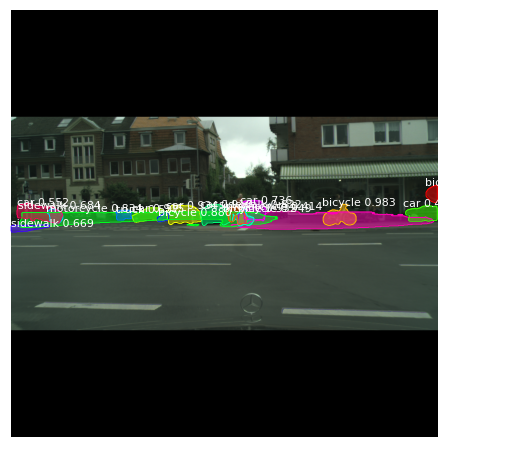

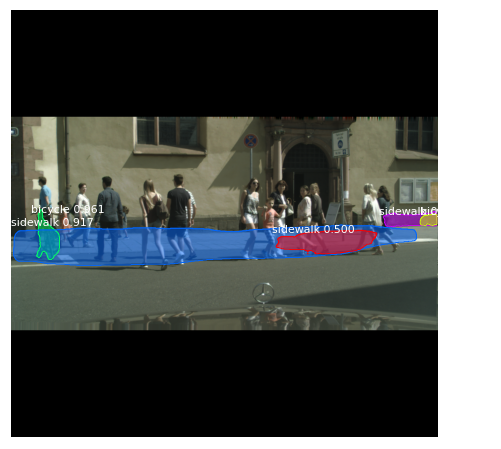

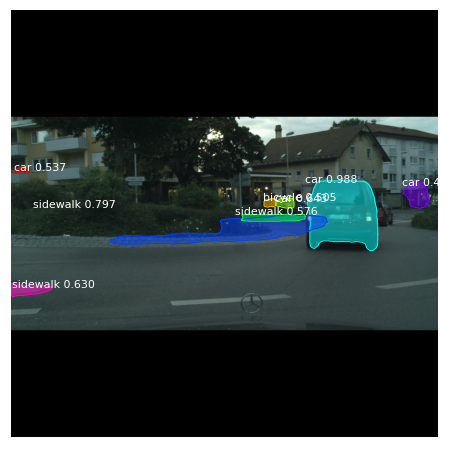

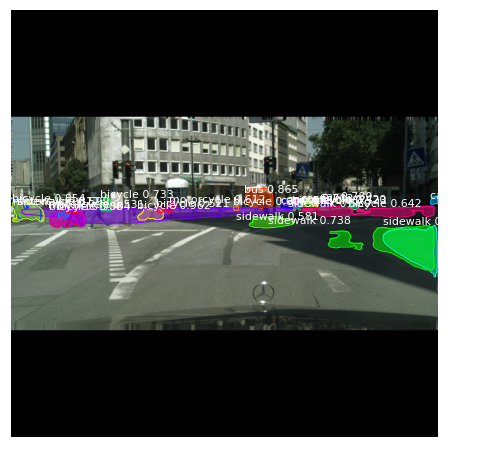

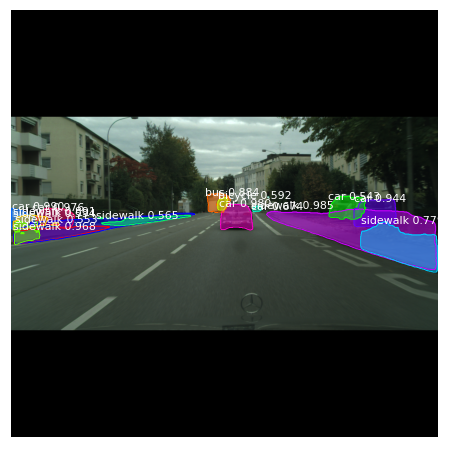

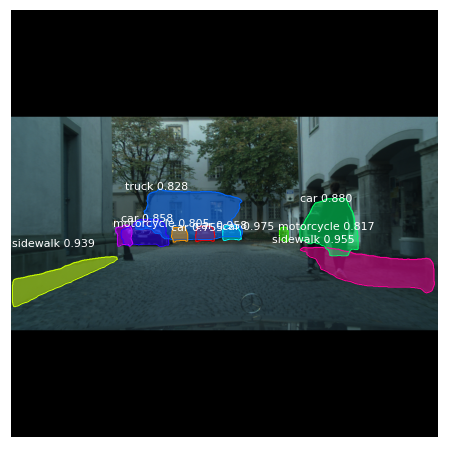

In [21]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = r'C:\Users\Soham\Dropbox (ASU)\ASU_StudyMaterials\Fall21\SML\Project\mask_r_cnn_sml\logs\cityscape20211116T1157\mask_rcnn_cityscape_0001.h5'
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)

model.load_weights(model_path, by_name=True)

# Test on random images
image_ids = np.random.choice(dataset_val.image_ids, 10)
for image_id in image_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    results = model.detect([original_image], verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                                dataset_val.class_names, r['scores'], ax=get_ax(), show_bbox=False)
                                

# batch = []
# class_names = [
#     'car',
# ]
# IMAGE_DIR = os.path.join(ROOT_DIR, "processed_data/leftImg8bit/test")
# file_names = next(os.walk(IMAGE_DIR))[2]
# random_files = np.random.choice(file_names, 2)
# for random_file in random_files:
#     image = skimage.io.imread(os.path.join(IMAGE_DIR, random_file))

#     # Run detection
#     results = model.detect([image], verbose=1)
#     r = results[0]

#     # Visualize results
#     visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
#                                 class_names, r['scores'])

In [28]:

# Compute mAP
#APs_05: IoU = 0.5
#APs_all: IoU from 0.5-0.95 with increments of 0.05
image_ids = np.random.choice(dataset_val.image_ids, 489)
APs_05 = []
APs_all = []
print(f'processing {len(image_ids)} APs and a5 are {image_ids[:5]}')

for image_id in image_ids:
    
    # Load images and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask = \
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # print('1'*100)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # print('2'*100)
    
    # Compute AP
    AP_05, precisions, recalls, overlaps = \
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs_05.append(AP_05)
    # print('3'*100)

    AP_all = \
        utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'], verbose=0)
    APs_all.append(AP_all)
    # print('4'*100)

print("mAP: ", np.mean(APs_05))
print("mAP: ", np.mean(APs_all))

processing 489 APs and a5 are [ 40  55   4 109 426]
mAP:  0.35700543615701713
mAP:  0.2187895547241683


In [29]:
APs_05 = [x if x else 0 for x in APs_05]
APs_all = [x if x else 0 for x in APs_all]

In [30]:
!pip install pandas
import pandas as pd
aps05 = pd.Series(APs_05)
aps05.head()

0    0.244444
1    0.166667
2    0.050000
3    0.500000
4    0.333333
dtype: float64

In [31]:
aps05.fillna(0, inplace=True)
aps05.mean()

0.35700543615701713

In [32]:
apsAll = pd.Series(APs_all)
apsAll.fillna(0, inplace=True)
apsAll.mean()

0.2187895547241683

In [33]:
print("mAP: ", np.mean(APs_05))
print("mAP: ", np.mean(APs_all))

mAP:  0.35700543615701713
mAP:  0.2187895547241683
